# Cross Comparison

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from uncertainty_motion_prediction.dataloader import Dataloader

dataset=Dataloader();


In [2]:
from uncertainty_motion_prediction.evaluators import DistanceErrorEvaluator

from uncertainty_motion_prediction.predictor import ConstantVelocityPredictor
from uncertainty_motion_prediction.predictor import ConstantVelocityKFPredictor
from uncertainty_motion_prediction.predictor import (
    HMMMultinomialFirstOrder, HMMLatentSegmentsExtractor, KMeansOutcome, HMMLatentSegmentsPredictor
)
clustering = KMeansOutcome.load_from_file("./hmm_segment_clustering.pickle")
state_dim = 80
hmm = HMMMultinomialFirstOrder(state_dim, clustering.N, verbose=True, max_iters=3)
hmm.load_from_file("./hmm_model_param.pickle")


algos =[['cvm', ConstantVelocityPredictor(N_future=4, dt=0.4)],
        ['kf' , ConstantVelocityKFPredictor(N_future=4,dt=0.4)],
        ['hmm' , HMMLatentSegmentsPredictor(hmm, clustering)]
]

In [3]:
res = []
evaluator = DistanceErrorEvaluator(N_future=4)
for i in range(len(dataset.get_key())):
    traj_dataset = dataset.load(i)
    trajlets = traj_dataset.get_trajlets(length=4.8, to_numpy=True)
    res_algos ={}
    for pred in algos:
        evaluator.evaluate(pred[1], trajlets)
        res_algos.update({pred[0]:evaluator.statistic()})
    res.append([dataset.get_key()[i], res_algos])
        

/home/kurisu/nus-cs5340/uncertainty-motion-prediction/src/uncertainty_motion_prediction/predictor/hmm_latent_segments.py:32: RuntimeWarning: invalid value encountered in true_divide
  x, y = dir / np.linalg.norm(dir)
/home/kurisu/nus-cs5340/uncertainty-motion-prediction/src/uncertainty_motion_prediction/predictor/hmm_latent_segments.py:32: RuntimeWarning: invalid value encountered in true_divide
  x, y = dir / np.linalg.norm(dir)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


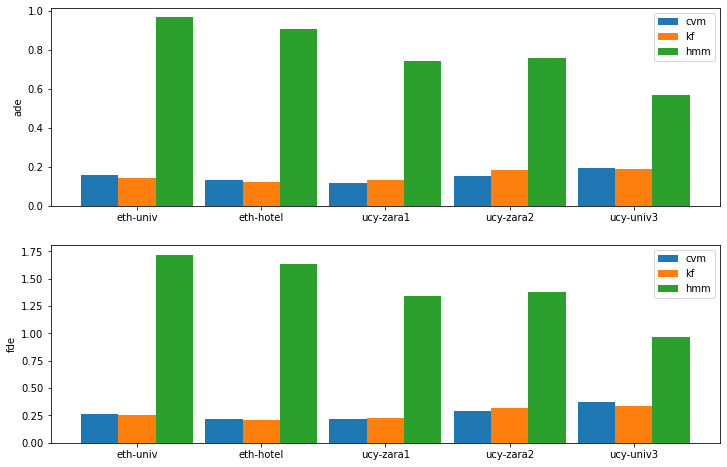

In [4]:
metrices  = evaluator.get_metrics()

fig, axs = plt.subplots(len(metrices),1, figsize=(12, 8))
labels = dataset.get_key()
x = np.arange(len(labels))

width = 0.3

for m_index in range(len(metrices)):
    m  = metrices[m_index]
    axs[m_index].set_ylabel(m)
    axs[m_index].legend()
    name = []
    
    for algo_index in range(len(algos)):
        algo = algos[algo_index]
        value =[]
        for i in res:
            value.append(i[1][algo[0]][m][0])
            
        axs[m_index].bar(x +  (width * (float(algo_index + 0.5)-float(len(algos))/2.0) ) , value, width, label=algo[0])
        
    axs[m_index].set_xticks(x)
    axs[m_index].set_xticklabels(labels)
    axs[m_index].legend()

        